In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency

#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
#from sklearn.linear_model import LinearRegression, Lasso, Ridge
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df = pd.read_csv("Sales_Data.csv",encoding="cp1252")

In [4]:
df.shape

(128949, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128949 entries, 0 to 128948
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Order ID            128949 non-null  object 
 1   Date                128949 non-null  object 
 2   Status              128949 non-null  object 
 3   Fulfilment          128949 non-null  object 
 4   Sales_Channel       128949 non-null  object 
 5   ship_service_level  128949 non-null  object 
 6   Style               128949 non-null  object 
 7   SKU                 128949 non-null  object 
 8   Category            128949 non-null  object 
 9   Size                128949 non-null  object 
 10  ASIN                128949 non-null  object 
 11  Courier_Status      122078 non-null  object 
 12  Qty                 128949 non-null  int64  
 13  currency            121155 non-null  object 
 14  Amount              121155 non-null  float64
 15  ship_city           128916 non-nul

In [5]:
df.describe()

,Qty,Amount,ship_postal-code
count,128949.000000,121155.000000,128916.000000
mean,0.904629,648.550806,463978.298008
std,0.314782,281.218324,191473.322953
min,0.000000,0.000000,110001.000000
25%,1.000000,449.000000,382421.000000
50%,1.000000,605.000000,500033.000000
75%,1.000000,788.000000,600024.000000
max,15.000000,5584.000000,989898.000000


In [ ]:
df.shape

In [16]:
df.isnull().sum()

Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales_Channel             0
ship_service_level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier_Status         6871
Qty                       0
currency               7791
Amount                 7791
ship_city                33
ship_state               33
ship_postal-code         33
ship_country             33
promotion-ids         49139
B2B                       0
fulfilled_by          89672
Unnamed: 22           49039
date_clean                0
dtype: int64

## Dropping duplicates based on orderid, style,skus

In [5]:
df = df.drop_duplicates(
    subset=['Order ID', 'Style', 'SKU'],
    keep='first'
)

## Cleaning & Formatting date column

In [6]:
df['date_clean'] = pd.to_datetime(
    df['Date'],
    errors='coerce'
)

In [7]:
df['year'] = df['date_clean'].dt.year
df['month'] = df['date_clean'].dt.month
df['quarter'] = df['date_clean'].dt.quarter

In [8]:
df.loc[df['Amount'] == 0, 'Amount'] = np.nan

In [9]:
df['Amount'] = df['Amount'].fillna(
    df.groupby('Style')['Amount'].transform('median')
)

df['Amount'] = df['Amount'].fillna(df['Amount'].median())

In [12]:
df["Is_Cancelled"] = df["Status"].isin(["Cancelled", "Shipped - Returned to Seller",
                                        "Shipped - Rejected by Buyer","Shipped - Returning to Seller"]).astype(int)

df["Order_Success"] = df["Status"].isin(
    ["Shipped - Delivered to Buyer", "Shipped"]
).astype(int)

df["In_Process"] = df["Status"].isin(
    ["Shipped - Lost in Transit", "Shipped - Out for Delivery",
     "Shipped - Picked Up","Pending","Pending - Waiting for Pick Up","Shipped - Damaged","Shipping"]
).astype(int)

In [23]:
df['Amount'].isnull().sum()

0

In [24]:
df[df['Amount'].isna()]

,Order ID,Date,Status,Fulfilment,Sales_Channel,ship_service_level,Style,SKU,Category,Size,...,Amount,ship_city,ship_state,ship_postal-code,ship_country,promotion-ids,B2B,fulfilled_by,Unnamed: 22,date_clean


## Univariate Analysis

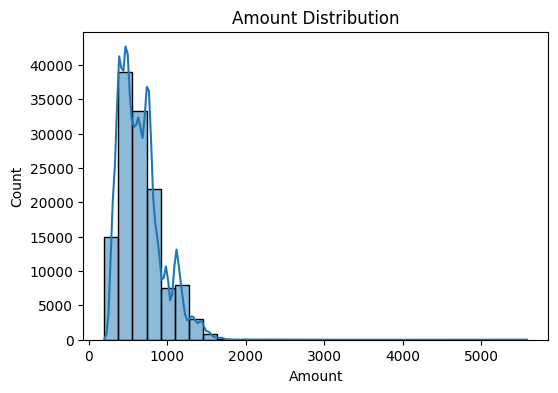

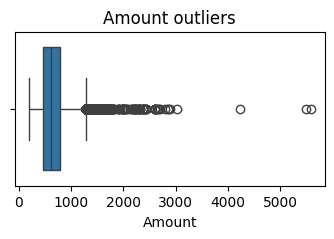

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=30, kde=True)
plt.title("Amount Distribution")
plt.show()

plt.figure(figsize=(4,2))
sns.boxplot(x=df["Amount"])
plt.title("Amount outliers")
plt.show()

In [ ]:
As per the histogram, we can see 250-1000 is the range which most of the people Ordering, 
Also as per the box plot there are also outliers where people have Ordered worth more than 3k.

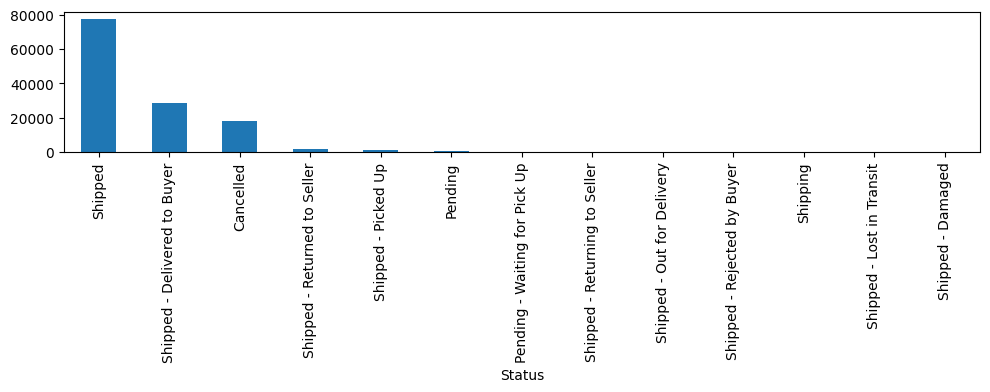

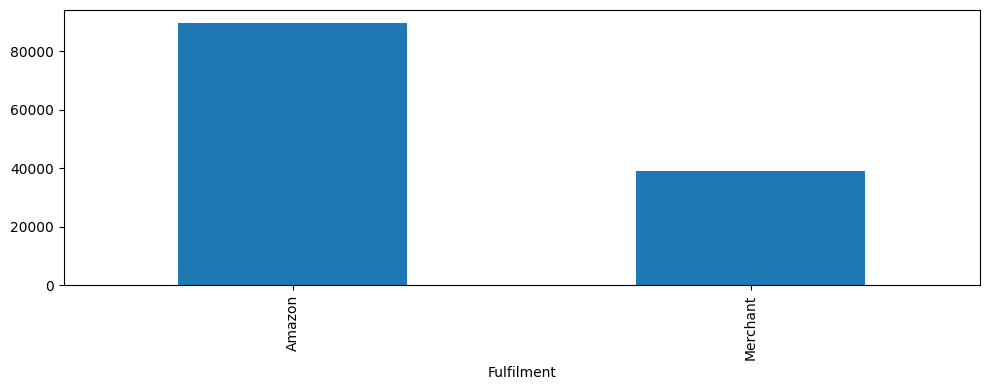

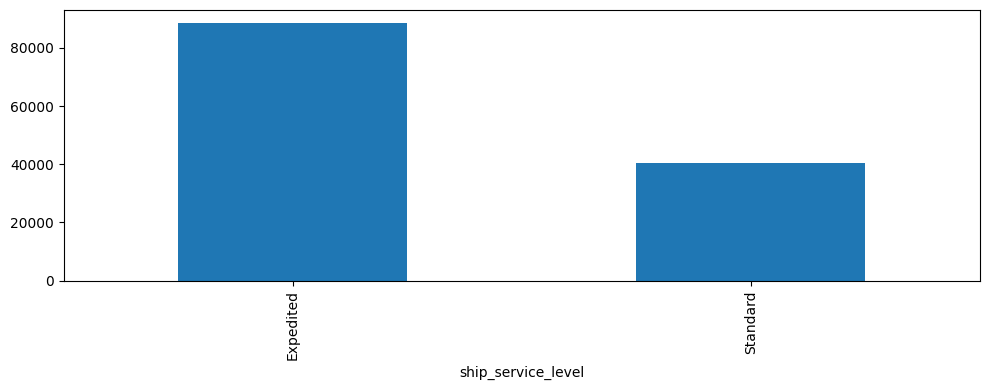

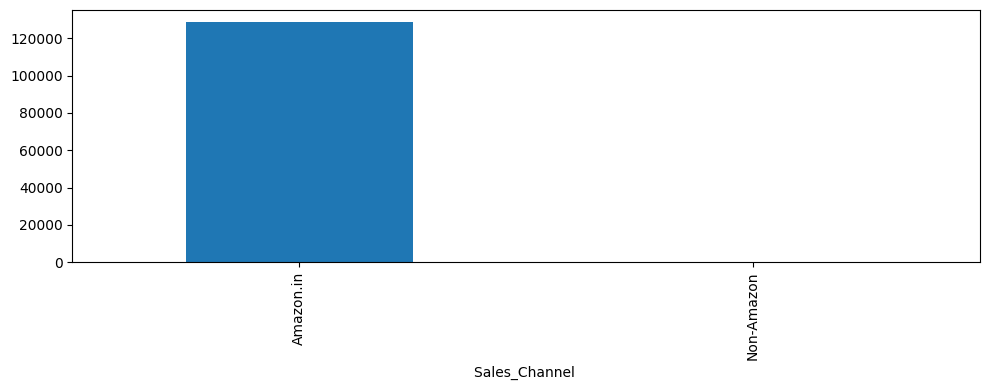

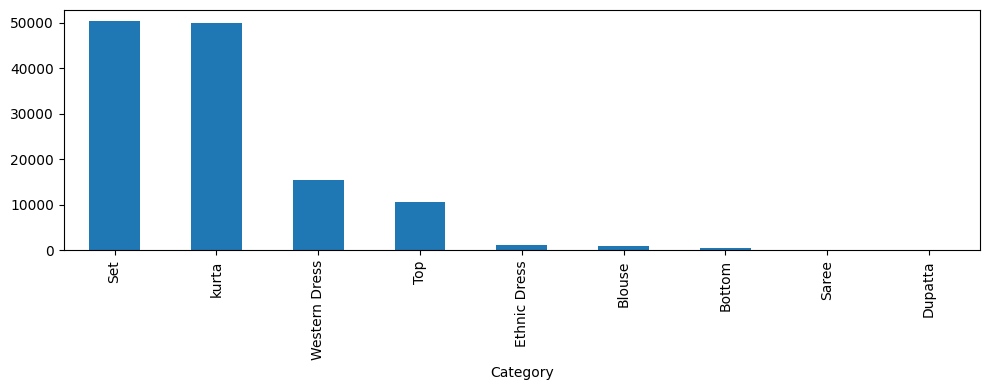

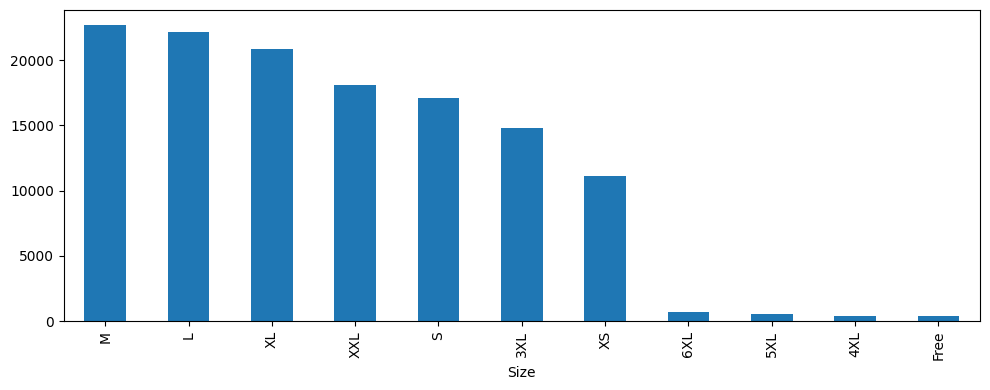

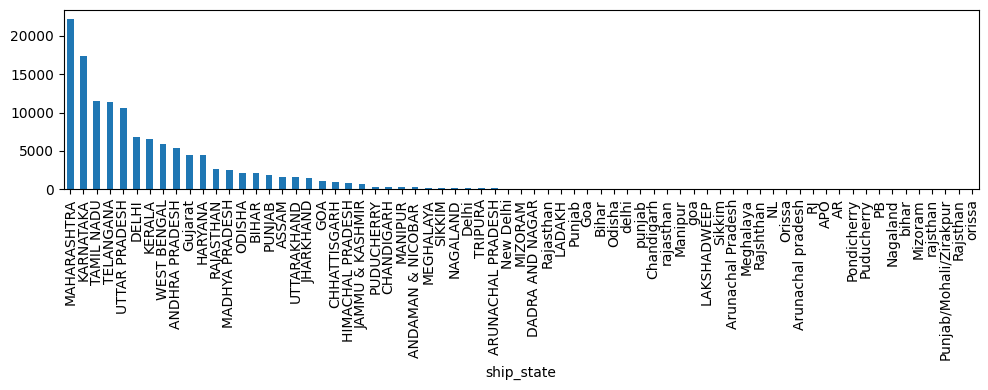

In [10]:
cols=['Status','Fulfilment','ship_service_level','Sales_Channel ','Category','Size','ship_state']
#clean_cols= [i.strip() for i in cols]

for i in cols:
    plt.figure(figsize=(10, 4))
    df[i].value_counts().plot(
        kind="bar")
    
    plt.xlabel(i)
    plt.tight_layout()
    plt.show()



In [ ]:
Most of the people have accepted the delivery than cancelling it.
Majorly fullfilled by amazon, followed by expedited facilty.Set & kurta seems to be the most ordered items.
Size M is the most ordered size indicating there are more of M size people.Highest no. of orders coming from maharashtra, karnataka, tamil nadu.

## Bivariate Analysis

In [ ]:
Financial performance analysis

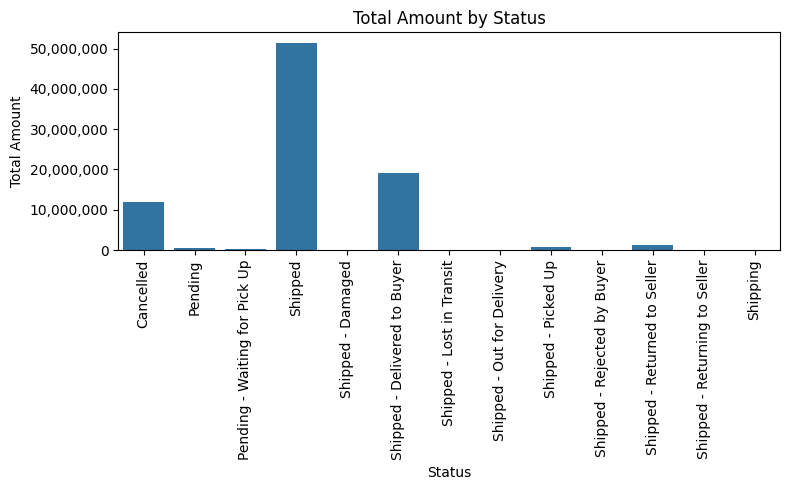

In [31]:
## relationship between amount and status.
import matplotlib.ticker as mtick

sum_df = (
    df.groupby('Status', as_index=False)['Amount']
    .sum()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=sum_df, x='Status', y='Amount')

plt.title('Total Amount by Status')
plt.ylabel('Total Amount')
plt.xlabel('Status')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

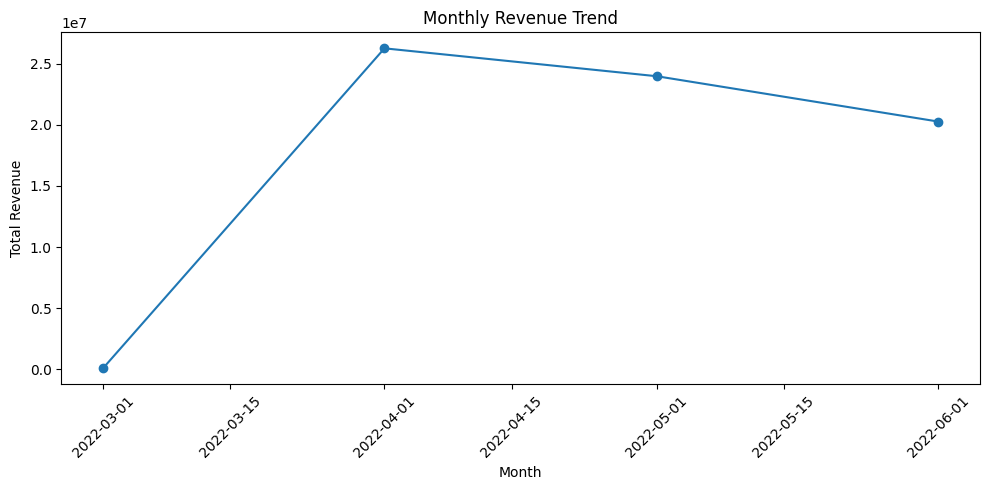

In [17]:
monthly_revenue = (
    df[df["Order_Success"] == 1].groupby(["year", "month"])["Amount"]
    .sum()
    .reset_index()
)

monthly_revenue["Year_Month"] = pd.to_datetime(
    monthly_revenue["year"].astype(str) + "-" + monthly_revenue["month"].astype(str)
)

plt.figure(figsize=(10,5))
plt.plot(monthly_revenue["Year_Month"], monthly_revenue["Amount"], marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## best selling products

## top products by revenue

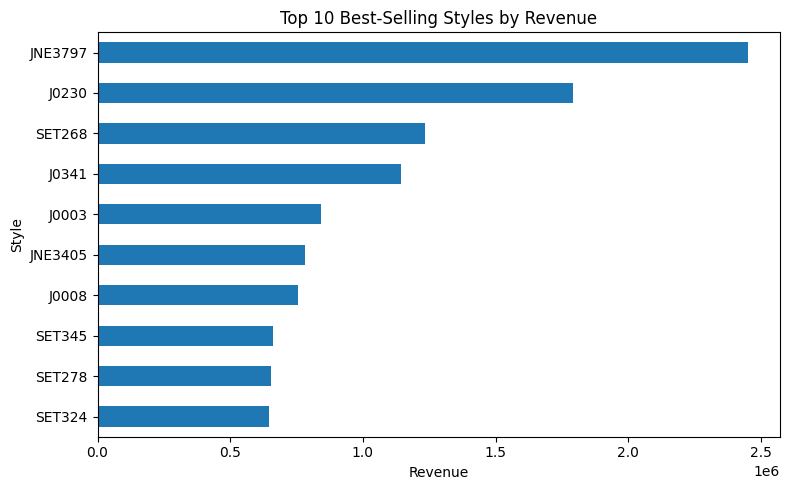

In [14]:
top_products = (
    df[df["Order_Success"] == 1].groupby("Style")["Amount"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
top_products.sort_values().plot(kind="barh")
plt.title("Top 10 Best-Selling Styles by Revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()


In [18]:
top_qty = (
    df[df["Order_Success"] == 1].groupby("Style")["Qty"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_qty

Style
JNE3797    3278
JNE3405    1911
SET268     1598
J0230      1558
J0341      1370
J0003      1257
SET324     1049
SET345     1041
JNE3373     975
JNE3399     892
Name: Qty, dtype: int64

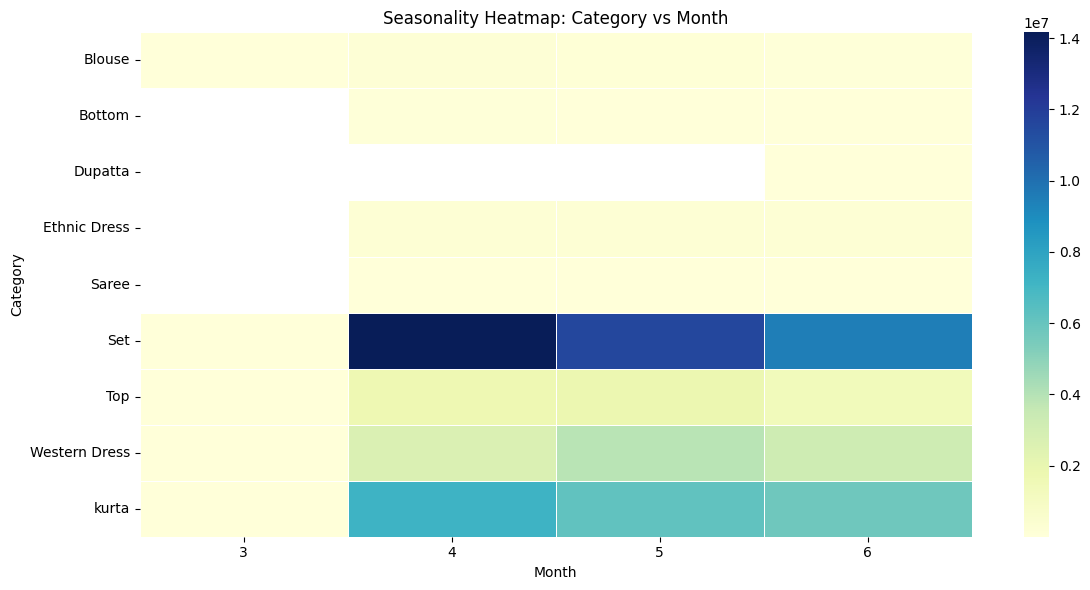

In [16]:
seasonality = (
    df[df["Order_Success"] == 1].groupby(["Category", "month"])["Amount"]
    .sum()
    .unstack()
)

plt.figure(figsize=(12,6))
sns.heatmap(seasonality, cmap="YlGnBu", linewidths=0.5)
plt.title("Seasonality Heatmap: Category vs Month")
plt.xlabel("Month")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

In [46]:
aov_category = (
    df.groupby("Category")
    .agg(
        Revenue=("Amount", "sum"),
        Orders=("Order ID", "nunique")
    )
)

aov_category["AOV"] = aov_category["Revenue"] / aov_category["Orders"]
aov_category.sort_values("AOV", ascending=False)


,Revenue,Orders,AOV
Category,,,
Saree,1.305345e+05,144,906.489444
Set,4.282242e+07,47836,895.192381
Western Dress,1.198310e+07,14989,799.459316
Ethnic Dress,8.615677e+05,1147,751.148788
Top,5.675528e+06,10154,558.945005
Blouse,4.938900e+05,897,550.602051
kurta,2.311732e+07,46551,496.602086
Dupatta,9.150000e+02,2,457.500000
Bottom,1.630740e+05,410,397.741415


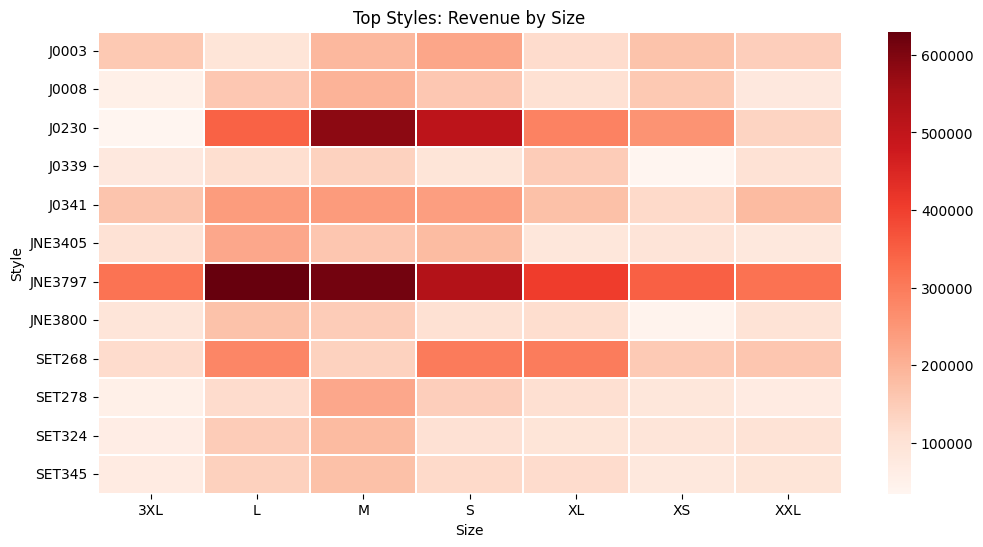

In [49]:
top_styles = (
    df.groupby("Style")["Amount"]
    .sum()
    .sort_values(ascending=False)
    .head(12)
    .index
)

filtered = df[df["Style"].isin(top_styles)]

pivot = (
    filtered.groupby(["Style", "Size"])["Amount"]
    .sum()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds", linewidths=0.3)
plt.title("Top Styles: Revenue by Size")
plt.show()


## Customer Insights

## Cancelled %age

In [55]:
cancel_rate = df["Is_Cancelled"].mean() * 100
cancel_rate


15.857517333374696

In [ ]:
16% of all orders do not convert to realized revenue.

## Cancelled by category

In [56]:
cancel_by_category = (
    df.groupby("Category")["Is_Cancelled"]
    .mean()
    .sort_values(ascending=False) * 100
)

cancel_by_category


Category
Set              16.275461
kurta            16.062010
Western Dress    15.927719
Bottom           15.000000
Ethnic Dress     13.989637
Blouse           13.822894
Saree            13.414634
Top              13.275586
Dupatta           0.000000
Name: Is_Cancelled, dtype: float64

In [57]:
cancel_by_size = (
    df.groupby("Size")["Is_Cancelled"]
    .mean()
    .sort_values(ascending=False) * 100
)

cancel_by_size


Size
XS      18.239670
S       16.867540
M       16.667401
L       15.822070
XL      15.303190
XXL     14.920670
3XL     14.206617
Free    13.984169
4XL     12.206573
5XL     12.000000
6XL     10.312076
Name: Is_Cancelled, dtype: float64

In [58]:
cancel_by_fulfilment = (
    df.groupby("Fulfilment")["Is_Cancelled"]
    .mean() * 100
)

cancel_by_fulfilment


Fulfilment
Amazon      12.797752
Merchant    22.844410
Name: Is_Cancelled, dtype: float64

In [59]:
df.groupby("Is_Cancelled")["Amount"].mean()


Is_Cancelled
0    663.280168
1    649.766177
Name: Amount, dtype: float64

In [62]:
## Differentiating B2B vs. B2C customer behavior for targeted marketing.

df.groupby("B2B").agg(
    Avg_Order_Value=("Amount", "mean"),
    Avg_Qty=("Qty", "mean"),
    Cancel_Rate=("Is_Cancelled", "mean")
)

,Avg_Order_Value,Avg_Qty,Cancel_Rate
B2B,,,
False,660.849682,0.904233,0.159013
True,703.411355,0.965557,0.094145


## Logistic & Fulfilment Optimization

In [64]:
fulfilment_perf = df.groupby("Fulfilment").agg(
    Order_Success_Rate=("Order_Success", "mean"),
    In_Process_Rate=("In_Process", "mean"),
    Cancellation_Rate=("Is_Cancelled", "mean"),
    Avg_Order_Value=("Amount", "mean"),
    Orders=("Order ID", "count")
)

fulfilment_perf[["Order_Success_Rate", "Cancellation_Rate","In_Process_Rate"]] *= 100
fulfilment_perf

,Order_Success_Rate,In_Process_Rate,Cancellation_Rate,Avg_Order_Value,Orders
Fulfilment,,,,,
Amazon,86.730529,0.471719,12.797752,661.323425,89672
Merchant,73.239114,3.916476,22.844410,660.711911,39270


In [ ]:
Due to the absence of shipment or delivery timestamps, direct measurement of shipping duration was not possible. 
Logistics performance was therefore assessed using outcome-based proxies such as order success rate, cancellation rate, 
and fulfilment reliability across fulfilment models, geographies, and courier statuses.
Insights:
1.Amazon fulfilment is more reliable than Merchant.
2.Merchant fulfilment shows higher cancellation risk.
Fulfilment choice impacts realized revenue.


## PRODUCT MANAGEMENT & INVENTORY OPTIMIZATION

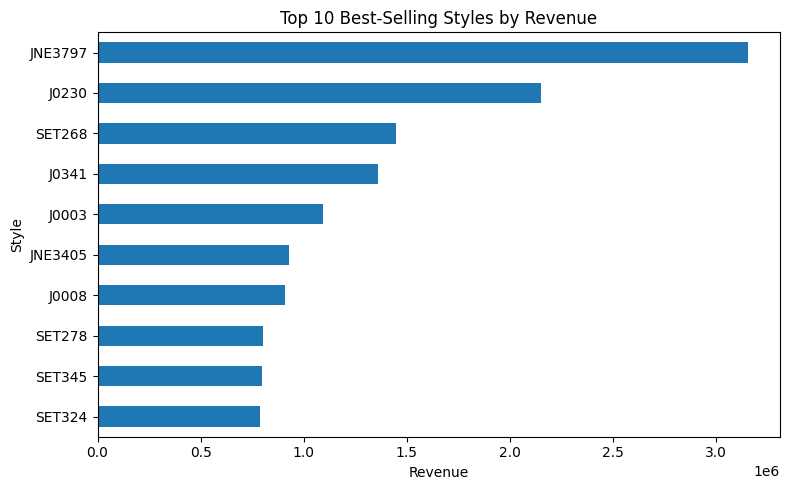

In [65]:
## Identifying high-demand product categories.

top_products = (
    df.groupby("Style")["Amount"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8,5))
top_products.sort_values().plot(kind="barh")
plt.title("Top 10 Best-Selling Styles by Revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()

In [ ]:
Since we don’t have warehouse stock or lead-time data, 
this is a demand-side inventory optimization, which is perfectly valid.

In [66]:
df["Qty"].describe()

count    128942.000000
mean          0.904647
std           0.314759
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          15.000000
Name: Qty, dtype: float64

In [ ]:
Mean → typical order size
75th / 90th percentile → bulk or high-demand orders

Business meaning : How many units customers usually buy per order.

In [72]:
## Avg qty per style

avg_qty_style = (
    df.groupby(["Style","Category"])["Qty"]
    .mean()
    .sort_values(ascending=False)
)

avg_qty_style.head(10)

Style   Category
BL017   Blouse      5.666667
BL020   Blouse      2.000000
SAR135  Saree       1.666667
BL086   Blouse      1.333333
BL022   Blouse      1.250000
SET442  Set         1.250000
SET315  Set         1.250000
AN211   Bottom      1.166667
SAR137  Saree       1.166667
SET083  Set         1.142857
Name: Qty, dtype: float64

In [81]:
avg_qty_style = (
    df.groupby(["Style","Category"])["Qty"]
    .mean()
    .sort_values(ascending=False)
)

avg_qty_style.head(10)

Style   Category
BL017   Blouse      5.666667
BL020   Blouse      2.000000
SAR135  Saree       1.666667
BL086   Blouse      1.333333
BL022   Blouse      1.250000
SET442  Set         1.250000
SET315  Set         1.250000
AN211   Bottom      1.166667
SAR137  Saree       1.166667
SET083  Set         1.142857
Name: Qty, dtype: float64

In [ ]:
Categories & Styles with higher average quantity like Blouse of these two styles(BL017,BL020) need faster replenishment cycles.

In [78]:
avg_qty_size = (
    df.groupby("Size")["Qty"]
    .median()
    .sort_values(ascending=False)
)

avg_qty_size


Size
3XL     1.0
4XL     1.0
5XL     1.0
6XL     1.0
Free    1.0
L       1.0
M       1.0
S       1.0
XL      1.0
XS      1.0
XXL     1.0
Name: Qty, dtype: float64

In [ ]:
avg order for all sizes are same which is 1.

In [79]:
## High demand styles(stockout risk)

style_demand = df.groupby("Style").agg(
    Avg_Qty=("Qty", "mean"),
    Total_Qty=("Qty", "sum"),
    Orders=("Order ID", "count")
)

style_demand.sort_values("Total_Qty", ascending=False).head(10)


,Avg_Qty,Total_Qty,Orders
Style,,,
JNE3797,0.874290,3693,4224
JNE3405,0.913351,2066,2262
SET268,0.931183,1732,1860
J0230,0.915908,1710,1867
J0341,0.903067,1472,1630
J0003,0.854333,1390,1627
SET324,0.897975,1153,1284
SET345,0.907200,1134,1250
JNE3373,0.912191,1070,1173


In [ ]:
JNE3797,JNE3405,SET268 are more consumed styles of all.

## Slow movers

In [82]:
slow_movers = style_demand[
    (style_demand["Orders"] < style_demand["Orders"].quantile(0.25)) &
    (style_demand["Total_Qty"] < style_demand["Total_Qty"].quantile(0.25))
]

slow_movers.head()


,Avg_Qty,Total_Qty,Orders
Style,,,
AN201,1.0,5,5
AN202,1.0,7,7
AN203,1.0,1,1
AN205,1.0,7,7
AN206,1.0,3,3


In [ ]:
Low order frequency, Low total movement -- Overstock risk

In [ ]:
Overstock risky sizes.

In [83]:
size_velocity = df.groupby("Size")["Qty"].sum().sort_values()

size_velocity


Size
Free      368
4XL       397
5XL       513
6XL       688
XS       9939
3XL     13525
S       15337
XXL     16511
XL      18928
L       19992
M       20449
Name: Qty, dtype: int64

## Size–Style Inventory Planning (Practical)

In [95]:
size_style_qty = (
    df.groupby(["Style", "Size"])["Qty"]
    .sum()
    #.unstack(fill_value=0)
)

size_style_qty.sort_values(ascending=False).head(10)


Style    Size
JNE3797  L       730
         M       699
         S       610
JNE3405  L       484
JNE3797  XL      473
J0230    M       470
         S       419
JNE3797  XS      411
JNE3405  S       399
JNE3797  XXL     387
Name: Qty, dtype: int64

In [ ]:
  Area	                   Recommendation
High Avg Qty Styles  	 Maintain higher safety stock
Core Sizes (M, L, etc.)	 Allocate disproportionate inventory
Slow-Moving Styles	     Reduce stock, use promotions
Category Planning	     Shorter replenishment cycles for high-qty categories


## Cancellation Rate by Category

## Status by category

In [96]:

cancel_by_category = (
    df.groupby("Category")["Is_Cancelled"]
    .mean()
    .sort_values(ascending=False) * 100
)

cancel_by_category


Category
Set              16.275461
kurta            16.062010
Western Dress    15.927719
Bottom           15.000000
Ethnic Dress     13.989637
Blouse           13.822894
Saree            13.414634
Top              13.275586
Dupatta           0.000000
Name: Is_Cancelled, dtype: float64

In [ ]:
Insight:
High cancellation categories → quality, fit, or expectation mismatch.
These categories require priority intervention.

## Order Success by category

In [100]:
Success_order_by_category = (
    df.groupby("Category")["Order_Success"]
    .mean()
    .sort_values(ascending=False) * 100
)

Success_order_by_category


Category
Dupatta          100.000000
Saree             85.975610
Blouse            85.529158
Top               85.321533
Ethnic Dress      85.233161
kurta             82.684556
Set               82.147120
Bottom            82.045455
Western Dress     81.716683
Name: Order_Success, dtype: float64

## In-Process by category

In [102]:
In_process_by_category = (
    df.groupby("Category")["In_Process"]
    .mean()
    .sort_values(ascending=False) * 100
)

In_process_by_category

Category
Bottom           2.954545
Western Dress    2.355599
Set              1.577419
Top              1.402881
kurta            1.253434
Ethnic Dress     0.777202
Blouse           0.647948
Saree            0.609756
Dupatta          0.000000
Name: In_Process, dtype: float64

## Identify Problematic Products (Style-level)

In [104]:
style_stats = df.groupby("Style").agg(
    Orders=("Order ID", "count"),
    Cancel_Rate=("Is_Cancelled", "mean")
)

problem_styles = style_stats[
    (style_stats["Orders"] >= 20) &   # avoid noise
    (style_stats["Cancel_Rate"] > style_stats["Cancel_Rate"].quantile(0.75))
].sort_values("Cancel_Rate", ascending=False)

problem_styles.head(10)


,Orders,Cancel_Rate
Style,,
SET195,24,0.458333
JNE3475,25,0.400000
JNE3608,77,0.376623
J0350,43,0.372093
J0292,32,0.343750
JNE3255,30,0.333333
JNE3488,21,0.333333
JNE3408,46,0.326087
BTM038,22,0.318182


In [ ]:
These are top 10 products where cancellation rate is observed to be very high, 
which might indicate that the style is not liked by people.
So, you can consider either putting high discount on remaining stocks to empty it or can think of improving these styles.

## Cancel by size

In [105]:
cancel_by_size = (
    df.groupby("Size")["Is_Cancelled"]
    .mean()
    .sort_values(ascending=False) * 100
)

cancel_by_size

Size
XS      18.239670
S       16.867540
M       16.667401
L       15.822070
XL      15.303190
XXL     14.920670
3XL     14.206617
Free    13.984169
4XL     12.206573
5XL     12.000000
6XL     10.312076
Name: Is_Cancelled, dtype: float64

In [ ]:
Insights:
1. High-cancel sizes → fit or sizing chart issues.
2. Action: revise size guide, images, descriptions.

In [ ]:
      Issue	                     Recommendation
High-return categories	   Improve product quality checks
Size-driven returns	       Update size charts & visuals
Problematic styles	       Pause promotions, review supplier
Merchant fulfilment	       Enforce stricter SLAs
Low-confidence orders	   Improve descriptions & reviews

## Cancel by fulfilment

In [106]:


cancel_by_fulfilment = (
    df.groupby("Fulfilment")["Is_Cancelled"]
    .mean() * 100
)

cancel_by_fulfilment


Fulfilment
Amazon      12.797752
Merchant    22.844410
Name: Is_Cancelled, dtype: float64

In [ ]:
Enforce stricter SLAs for fulfilments by merchants.


In [ ]:
In-short, In the absence of explicit customer feedback, I used returns and cancellations as dissatisfaction proxies,
identified high-risk products and categories using volume-adjusted metrics, and translated insights into concrete quality and service improvements.

In [108]:
df.columns

Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales_Channel ',
       'ship_service_level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier_Status', 'Qty', 'currency', 'Amount', 'ship_city',
       'ship_state', 'ship_postal-code', 'ship_country', 'promotion-ids',
       'B2B', 'fulfilled_by', 'Unnamed: 22', 'date_clean', 'year', 'month',
       'quarter', 'Is_Cancelled', 'Order_Success', 'In_Process'],
      dtype='object')

In [109]:
from sqlalchemy import create_engine

server = "DELL\SQLEXPRESS07"      # e.g. DESKTOP-ABC\\SQLEXPRESS
database = "EcommSalesAnalysis"

engine = create_engine(
    f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
)

In [130]:
df_sales = df.rename(columns={"Order ID": "Order_ID","date_clean":"Date_Clean","year":"Year_1","month":"Month_1",
                              "quarter":"Quarter_1","promotion-ids":"promotion_ids","Sales_Channel ":"Sales_Channel","Status": "Status_1"})



In [136]:
SalesData_sql = df_sales[
    [
        "Order_ID",
        "Date_Clean",
        "Status_1",
        "Fulfilment",
        "Sales_Channel",
        "ship_service_level",
        "Style",
        "SKU",
        "Category",
        "Size",
        "Qty",
        "Amount",
        "promotion_ids",
        "B2B",
        "fulfilled_by",
        'Year_1',
        'Month_1',
        'Quarter_1',
        'Is_Cancelled',
        'Order_Success',
        'In_Process'
        
        
    ]
]

SalesData_sql.to_sql(
    "EcommSalesAnalysis",
    engine,
    if_exists="append",
    index=False,
    chunksize=10000
)



44